# Price Elasticity Analysis - Notebook 2: Data Cleaning

This notebook focuses on cleaning and preprocessing the sales data for price elasticity analysis.

## Objectives
- Handle missing values and data quality issues
- Remove outliers and invalid data points
- Standardize data formats and types
- Create clean dataset for analysis
- Document cleaning decisions and transformations


In [1]:
# Data refreshed: 2025-06-24
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path

# Add project root to Python path so we can import src modules
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.utils.data_helpers import clean_sales_data, validate_data_quality, save_processed_data
from src.utils.plot_helpers import setup_plot_style, plot_distribution

# Configure plotting
setup_plot_style()

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# ==========================================
# PHASE 1: DATA LOADING & INITIAL ASSESSMENT
# ==========================================

print("🔄 Loading raw data from parquet...")

# Load the raw data
RAW_DATA_PATH = Path("../data/raw/iri_sales_data.parquet")
df_raw = pd.read_parquet(RAW_DATA_PATH)

print(f"✅ Loaded {len(df_raw):,} rows and {len(df_raw.columns)} columns")
print(f"📊 Data shape: {df_raw.shape}")
print(f"💾 Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display basic info
print("\n📋 COLUMN SUMMARY:")
print(f"Total columns: {len(df_raw.columns)}")
print(f"Numeric columns: {len(df_raw.select_dtypes(include=[np.number]).columns)}")
print(f"Object columns: {len(df_raw.select_dtypes(include=['object']).columns)}")

# Show first few rows
print("\n🔍 SAMPLE DATA:")
display(df_raw.head(3))


🔄 Loading raw data from parquet...


✅ Loaded 1,979,310 rows and 36 columns
📊 Data shape: (1979310, 36)


💾 Memory usage: 1182.0 MB

📋 COLUMN SUMMARY:
Total columns: 36
Numeric columns: 32
Object columns: 4

🔍 SAMPLE DATA:


,ID,Geography,Product,Time,Geography Key,Product Key,Unit Sales,Unit Sales Year Ago,Unit Sales 2 Years Ago,Unit Sales 3 Years Ago,...,Dollar Sales Year Ago,Dollar Sales 2 Years Ago,Dollar Sales 3 Years Ago,Incremental Dollars,Base Dollar Sales,Unit Sales per Pt of Distribution,Weighted Average Base Price Per Unit,Opportunity Dollars,Dollar Trade Efficiency,Unit Trade Efficiency
0,10147576,Total US - Multi Outlet,ACE OF DIAMONDS CHUNK LIGHT WATER 5 OZ 1 CT CA...,Week Ending 12-31-23,609857.0,452471233:225241880:59659909:460977384:7080095...,64.0,13.0,165.0,1132.0,...,19.0,186.0,937.0,NaN,106.0,970.0,1.67,270117.0,NaN,NaN
1,10147577,Total US - Multi Outlet,ACE OF DIAMONDS CHUNK LIGHT WATER 5 OZ 1 CT CA...,Week Ending 01-07-24,609857.0,452471233:225241880:59659909:460977384:7080095...,20.0,21.0,185.0,1816.0,...,32.0,170.0,1534.0,NaN,32.0,527.0,1.62,152402.0,NaN,NaN
2,10147578,Total US - Multi Outlet,CHICKEN OF THE SEA CHUNK LIGHT OIL 12 OZ 1 CT ...,Week Ending 12-31-23,609857.0,452471233:225241880:59659909:460977384:7080095...,8431.0,12740.0,16067.0,22362.0,...,37736.0,39876.0,57626.0,53.0,24969.0,424.0,2.97,237774.0,0.21,0.19


In [3]:
# ==========================================
# PHASE 2: TIME PARSING & DATA STRUCTURE
# ==========================================

print("🕒 Parsing IRI time format...")

# Use our custom IRI time parsing function
from src.utils.data_helpers import parse_iri_time_column, standardize_iri_columns

# Parse the time column
df_parsed = parse_iri_time_column(df_raw, time_column='Time')

print(f"✅ Time parsing complete")
print(f"📅 Date range: {df_parsed['date'].min()} to {df_parsed['date'].max()}")
print(f"📊 Unique time periods: {df_parsed['date'].nunique()}")

# Check time parsing results
print("\n🔍 TIME PARSING VALIDATION:")
# Show original time column and parsed date
time_sample = df_parsed[['Time', 'date']].head()
display(time_sample)

print(f"\n📋 SAMPLE DATE PARSING:")
print(f"Original: {df_parsed['Time'].iloc[0]}")
print(f"Parsed: {df_parsed['date'].iloc[0]}")

# Standardize column names (optional)
print("\n🔧 Applying column standardization...")
df_clean = standardize_iri_columns(df_parsed)

print(f"✅ Column standardization complete")
print("\n📋 KEY COLUMNS AFTER STANDARDIZATION:")
key_cols = ['date', 'quantity_sold', 'unit_price', 'revenue', 'volume']
available_key_cols = [col for col in key_cols if col in df_clean.columns]
print(f"Available: {available_key_cols}")


🕒 Parsing IRI time format...


INFO:src.utils.data_helpers:Successfully parsed IRI time format from Time


✅ Time parsing complete
📅 Date range: 2022-01-02 00:00:00 to 2025-06-15 00:00:00
📊 Unique time periods: 181

🔍 TIME PARSING VALIDATION:


,Time,date
0,Week Ending 12-31-23,2023-12-31
1,Week Ending 01-07-24,2024-01-07
2,Week Ending 12-31-23,2023-12-31
3,Week Ending 01-07-24,2024-01-07
4,Week Ending 12-31-23,2023-12-31



📋 SAMPLE DATE PARSING:
Original: Week Ending 12-31-23
Parsed: 2023-12-31 00:00:00

🔧 Applying column standardization...


INFO:src.utils.data_helpers:Standardized 3 IRI column names


✅ Column standardization complete

📋 KEY COLUMNS AFTER STANDARDIZATION:
Available: ['date']


In [4]:
df_clean.columns

Index(['ID', 'geography', 'product_name', 'time_original', 'Geography Key',
       'Product Key', 'Unit Sales', 'Unit Sales Year Ago',
       'Unit Sales 2 Years Ago', 'Unit Sales 3 Years Ago', 'Base Unit Sales',
       'Incremental Units', 'Volume Sales', '% Stores',
       'ACV Weighted Distribution Feature Only',
       'ACV Weighted Distribution Feature and Display',
       'ACV Weighted Distribution Display Only',
       'ACV Weighted Distribution Price Reductions Only',
       'ACV Weighted Distribution', 'Price per Unit',
       'Price per Unit Year Ago', 'Price per Unit Any Merch',
       'Price per Unit No Merch', 'Total Points of Distribution',
       'Total Points of Distribution Change vs YA', 'Dollar Sales',
       'Dollar Sales Year Ago', 'Dollar Sales 2 Years Ago',
       'Dollar Sales 3 Years Ago', 'Incremental Dollars', 'Base Dollar Sales',
       'Unit Sales per Pt of Distribution',
       'Weighted Average Base Price Per Unit', 'Opportunity Dollars',
       'Dollar T

In [5]:
# ==========================================
# PHASE 3: MISSING VALUE ANALYSIS
# ==========================================

print("🔍 Analyzing missing values...")

# Calculate missing value statistics
missing_stats = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / len(df_clean)) * 100,
    'Data_Type': df_clean.dtypes
}).sort_values('Missing_Percentage', ascending=False)

# Display missing value summary
print(f"📊 MISSING VALUE SUMMARY:")
print(f"Total columns: {len(missing_stats)}")
print(f"Columns with missing values: {len(missing_stats[missing_stats['Missing_Count'] > 0])}")
print(f"Completely missing columns: {len(missing_stats[missing_stats['Missing_Percentage'] == 100])}")

# Show top missing columns
print("\n🚨 TOP MISSING VALUE COLUMNS:")
top_missing = missing_stats[missing_stats['Missing_Count'] > 0].head(10)
display(top_missing)

# Visualize missing patterns for key business columns
business_key_columns = [
    'quantity_sold', 'unit_price', 'revenue', 'volume', 
    'store_penetration', 'distribution_acv'
]

available_business_cols = [col for col in business_key_columns if col in df_clean.columns]
print(f"\n📈 MISSING VALUES IN KEY BUSINESS COLUMNS:")
if available_business_cols:
    business_missing = missing_stats[missing_stats['Column'].isin(available_business_cols)]
    display(business_missing)
else:
    print("⚠️ Business columns not found with expected names")


🔍 Analyzing missing values...


📊 MISSING VALUE SUMMARY:
Total columns: 37
Columns with missing values: 30
Completely missing columns: 0

🚨 TOP MISSING VALUE COLUMNS:


,Column,Missing_Count,Missing_Percentage,Data_Type
ACV Weighted Distribution Feature and Display,ACV Weighted Distribution Feature and Display,1953774,98.709853,float64
ACV Weighted Distribution Feature Only,ACV Weighted Distribution Feature Only,1892950,95.636863,float64
ACV Weighted Distribution Display Only,ACV Weighted Distribution Display Only,1732626,87.536869,float64
ACV Weighted Distribution Price Reductions Only,ACV Weighted Distribution Price Reductions Only,998113,50.427321,float64
Incremental Units,Incremental Units,918240,46.391924,float64
Incremental Dollars,Incremental Dollars,918240,46.391924,float64
Dollar Trade Efficiency,Dollar Trade Efficiency,918240,46.391924,float64
Unit Trade Efficiency,Unit Trade Efficiency,918240,46.391924,float64
Price per Unit Any Merch,Price per Unit Any Merch,918240,46.391924,float64
Dollar Sales 3 Years Ago,Dollar Sales 3 Years Ago,417833,21.110033,float64



📈 MISSING VALUES IN KEY BUSINESS COLUMNS:
⚠️ Business columns not found with expected names


🎯 Detecting outliers in key variables...
🔢 Analyzing outliers in: []

📊 OUTLIER ANALYSIS SUMMARY:


""



📈 Creating distribution plots...


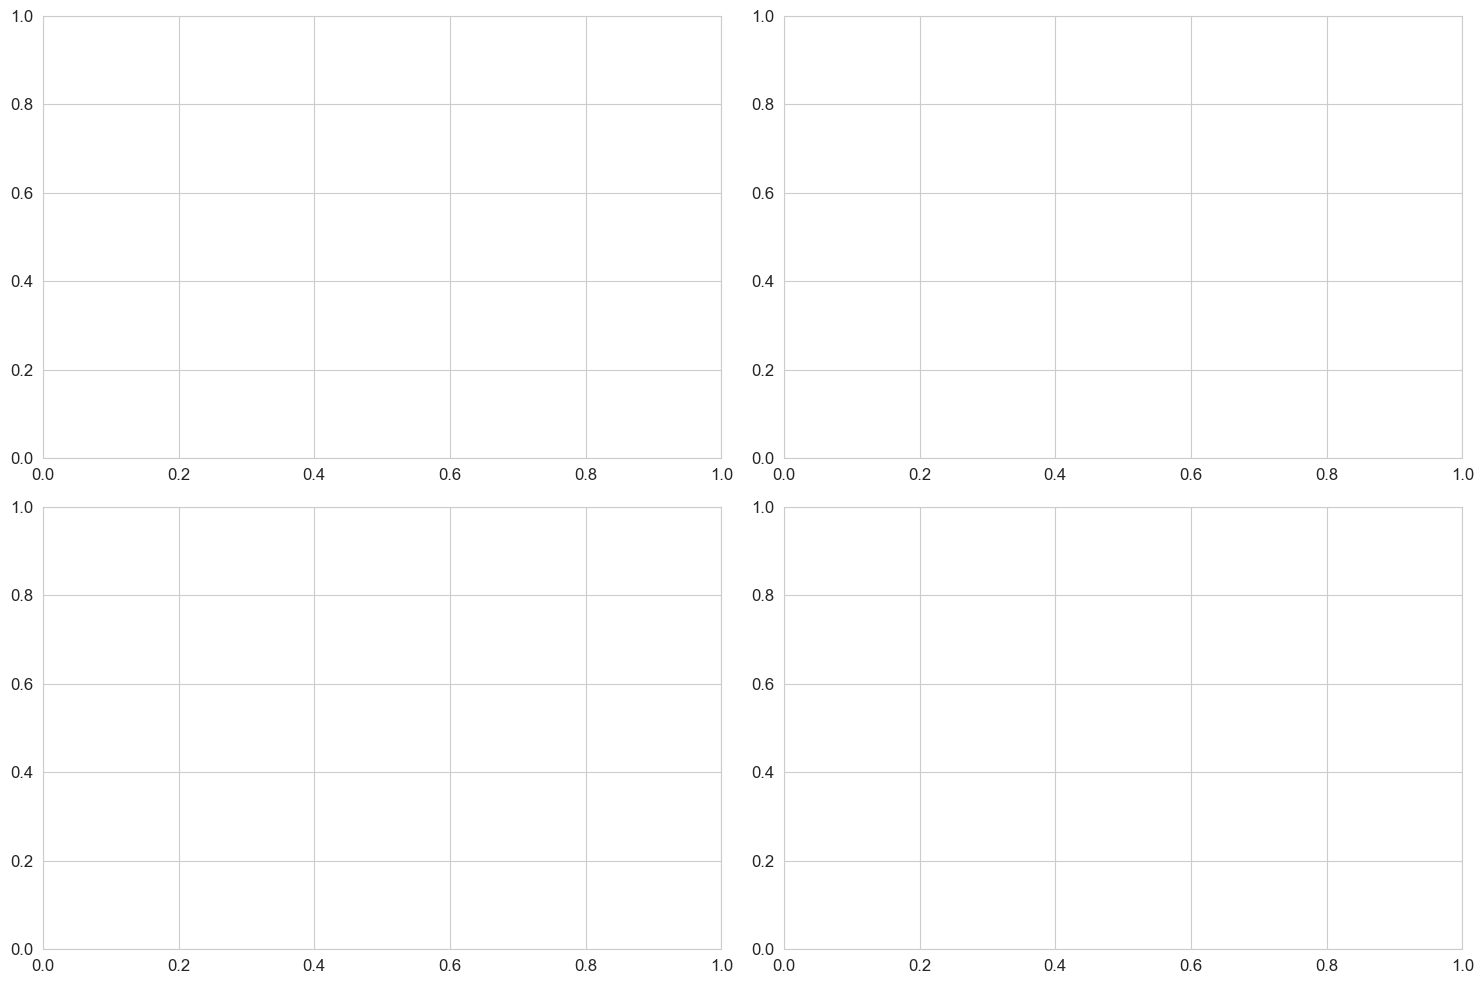

In [6]:
# ==========================================
# PHASE 4: OUTLIER DETECTION & ANALYSIS
# ==========================================

print("🎯 Detecting outliers in key variables...")

# Focus on key numeric columns for elasticity analysis
key_numeric_columns = ['quantity_sold', 'unit_price', 'revenue', 'volume']
available_numeric_cols = [col for col in key_numeric_columns if col in df_clean.columns]

print(f"🔢 Analyzing outliers in: {available_numeric_cols}")

# Statistical outlier detection using IQR method
def detect_outliers_iqr(series, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers, lower_bound, upper_bound

# Analyze outliers for each key column
outlier_summary = []

for col in available_numeric_cols:
    if col in df_clean.columns:
        # Remove missing values for analysis
        series_clean = df_clean[col].dropna()
        
        if len(series_clean) > 0:
            outliers, lower_bound, upper_bound = detect_outliers_iqr(series_clean)
            
            outlier_summary.append({
                'Column': col,
                'Total_Values': len(series_clean),
                'Outliers_Count': outliers.sum(),
                'Outliers_Percentage': (outliers.sum() / len(series_clean)) * 100,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound,
                'Min_Value': series_clean.min(),
                'Max_Value': series_clean.max(),
                'Median': series_clean.median()
            })

# Display outlier analysis
outlier_df = pd.DataFrame(outlier_summary)
print("\n📊 OUTLIER ANALYSIS SUMMARY:")
display(outlier_df)

# Visualize distributions and outliers
print("\n📈 Creating distribution plots...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(available_numeric_cols[:4]):
    if col in df_clean.columns:
        ax = axes[i]
        data = df_clean[col].dropna()
        
        # Create histogram
        ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
        ax.set_title(f'Distribution: {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        
        # Add outlier bounds as vertical lines
        outlier_info = outlier_df[outlier_df['Column'] == col]
        if not outlier_info.empty:
            lower_bound = outlier_info['Lower_Bound'].iloc[0]
            upper_bound = outlier_info['Upper_Bound'].iloc[0]
            ax.axvline(lower_bound, color='red', linestyle='--', alpha=0.7, label='Lower Bound')
            ax.axvline(upper_bound, color='red', linestyle='--', alpha=0.7, label='Upper Bound')
            ax.legend()

plt.tight_layout()
plt.show()


In [7]:
# ==========================================
# PHASE 5: DATA VALIDATION & QUALITY CHECKS
# ==========================================

print("✅ Performing data quality validation...")

# Use our utility function for data quality validation
required_columns = ['quantity_sold', 'unit_price', 'revenue', 'geography', 'product_name']
validation_results = validate_data_quality(
    df_clean, 
    required_columns=required_columns,
    price_column='unit_price',
    quantity_column='quantity_sold'
)

print("📋 DATA QUALITY VALIDATION RESULTS:")
for key, value in validation_results.items():
    print(f"  {key}: {value}")

# Business logic validation
print("\n🔍 BUSINESS LOGIC VALIDATION:")

# 1. Check for negative prices or quantities
negative_prices = (df_clean['unit_price'] < 0).sum() if 'unit_price' in df_clean.columns else 0
negative_sales = (df_clean['quantity_sold'] < 0).sum() if 'quantity_sold' in df_clean.columns else 0

print(f"  Negative prices: {negative_prices}")
print(f"  Negative unit sales: {negative_sales}")

# 2. Check price-volume relationship consistency
if all(col in df_clean.columns for col in ['unit_price', 'quantity_sold', 'revenue']):
    # Calculate expected dollar sales
    expected_dollar_sales = df_clean['unit_price'] * df_clean['quantity_sold']
    actual_dollar_sales = df_clean['revenue']
    
    # Find inconsistencies (allowing for small rounding errors)
    inconsistent = np.abs(expected_dollar_sales - actual_dollar_sales) > 0.01
    inconsistent_count = inconsistent.sum()
    
    print(f"  Price × Quantity ≠ Dollar Sales: {inconsistent_count} records ({inconsistent_count/len(df_clean)*100:.2f}%)")

# 3. Check for extreme price variations within products
if all(col in df_clean.columns for col in ['product_name', 'unit_price']):
    price_stats_by_product = df_clean.groupby('product_name')['unit_price'].agg(['min', 'max', 'std']).reset_index()
    price_stats_by_product['price_range'] = price_stats_by_product['max'] - price_stats_by_product['min']
    price_stats_by_product['cv'] = price_stats_by_product['std'] / df_clean.groupby('product_name')['unit_price'].mean().values
    
    extreme_variation = price_stats_by_product[price_stats_by_product['cv'] > 0.5]  # CV > 50%
    print(f"  Products with extreme price variation (CV > 50%): {len(extreme_variation)}")

# 4. Temporal consistency checks
if 'date' in df_clean.columns:
    date_gaps = df_clean['date'].sort_values().diff().dt.days
    max_gap = date_gaps.max()
    print(f"  Maximum gap between time periods: {max_gap} days")
    
    # Check for duplicate time-product-geography combinations
    if all(col in df_clean.columns for col in ['date', 'product_name', 'Geography']):
        duplicates = df_clean.duplicated(subset=['date', 'product_name', 'Geography']).sum()
        print(f"  Duplicate time-product-geography records: {duplicates}")


✅ Performing data quality validation...


INFO:src.utils.data_helpers:Data validation completed. Found 3 missing columns, 14121222 missing values


📋 DATA QUALITY VALIDATION RESULTS:
  total_rows: 1979310
  missing_columns: ['quantity_sold', 'unit_price', 'revenue']
  missing_values: {'Unit Sales': np.int64(54503), 'Unit Sales Year Ago': np.int64(219288), 'Unit Sales 2 Years Ago': np.int64(333776), 'Unit Sales 3 Years Ago': np.int64(417833), 'Base Unit Sales': np.int64(60793), 'Incremental Units': np.int64(918240), 'Volume Sales': np.int64(54503), '% Stores': np.int64(54503), 'ACV Weighted Distribution Feature Only': np.int64(1892950), 'ACV Weighted Distribution Feature and Display': np.int64(1953774), 'ACV Weighted Distribution Display Only': np.int64(1732626), 'ACV Weighted Distribution Price Reductions Only': np.int64(998113), 'ACV Weighted Distribution': np.int64(54504), 'Price per Unit': np.int64(54503), 'Price per Unit Year Ago': np.int64(219288), 'Price per Unit Any Merch': np.int64(918240), 'Price per Unit No Merch': np.int64(103668), 'Total Points of Distribution': np.int64(54504), 'Total Points of Distribution Change vs 

  Maximum gap between time periods: 7.0 days


In [8]:
# ==========================================
# PHASE 6: CLEANING TRANSFORMATIONS
# ==========================================

print("🧹 Applying data cleaning transformations...")

# Create a copy for cleaning
df_cleaned = df_clean.copy()

# 1. MISSING VALUE TREATMENT
print("\n1️⃣ Handling missing values...")

# Drop rows where key business metrics are ALL missing
key_business_cols = ['quantity sold', 'unit_price', 'revenue']
available_key_cols = [col for col in key_business_cols if col in df_cleaned.columns]

if available_key_cols:
    # Drop rows where ALL key columns are missing
    before_rows = len(df_cleaned)
    df_cleaned = df_cleaned.dropna(subset=available_key_cols, how='all')
    dropped_rows = before_rows - len(df_cleaned)
    print(f"  Dropped {dropped_rows} rows with all key metrics missing")

# Handle missing values in specific columns based on business logic
# Example: Fill missing promotional variables with 0 (assuming no promotion)
promo_columns = [
    'ACV Weighted Distribution Feature Only',
    'ACV Weighted Distribution Display Only', 
    'Incremental Units',
    'Incremental Dollars'
]

for col in promo_columns:
    if col in df_cleaned.columns:
        missing_before = df_cleaned[col].isnull().sum()
        df_cleaned[col] = df_cleaned[col].fillna(0)
        print(f"  Filled {missing_before} missing values in {col} with 0")

# 2. OUTLIER TREATMENT
print("\n2️⃣ Treating outliers...")

# Define outlier treatment strategy
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    """Cap outliers at specified percentiles"""
    lower_bound = series.quantile(lower_percentile / 100)
    upper_bound = series.quantile(upper_percentile / 100)
    
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply outlier capping to key variables
outlier_columns = ['quantity_sold', 'unit_price']
for col in outlier_columns:
    if col in df_cleaned.columns:
        original_min = df_cleaned[col].min()
        original_max = df_cleaned[col].max()
        
        df_cleaned[col] = cap_outliers(df_cleaned[col], lower_percentile=1, upper_percentile=99)
        
        new_min = df_cleaned[col].min()
        new_max = df_cleaned[col].max()
        
        print(f"  {col}: Capped range from [{original_min:.2f}, {original_max:.2f}] to [{new_min:.2f}, {new_max:.2f}]")

# 3. DATA TYPE OPTIMIZATION
print("\n3️⃣ Optimizing data types...")

# Convert categorical columns to category type for memory efficiency
categorical_columns = ['geography', 'product_name']
for col in categorical_columns:
    if col in df_cleaned.columns:
        original_memory = df_cleaned[col].memory_usage(deep=True)
        df_cleaned[col] = df_cleaned[col].astype('category')
        new_memory = df_cleaned[col].memory_usage(deep=True)
        memory_saved = (original_memory - new_memory) / 1024**2
        print(f"  {col}: Converted to category, saved {memory_saved:.1f} MB")

# 4. FINAL CLEANUP
print("\n4️⃣ Final cleanup...")

# Remove temporary columns created during processing
temp_columns = ['date_str', 'Time']  # Keep original Time for reference, but add to temp if not needed
cleanup_columns = [col for col in temp_columns if col in df_cleaned.columns]

if cleanup_columns:
    df_cleaned = df_cleaned.drop(columns=cleanup_columns)
    print(f"  Removed temporary columns: {cleanup_columns}")

# Summary of cleaning results
print(f"\n✅ CLEANING COMPLETE!")
print(f"📊 Final dataset shape: {df_cleaned.shape}")
print(f"💾 Memory usage: {df_cleaned.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display final data sample
print("\n🔍 CLEANED DATA SAMPLE:")
display(df_cleaned.head())


🧹 Applying data cleaning transformations...

1️⃣ Handling missing values...


  Filled 1892950 missing values in ACV Weighted Distribution Feature Only with 0


  Filled 1732626 missing values in ACV Weighted Distribution Display Only with 0
  Filled 918240 missing values in Incremental Units with 0
  Filled 918240 missing values in Incremental Dollars with 0

2️⃣ Treating outliers...

3️⃣ Optimizing data types...


  geography: Converted to category, saved 126.5 MB


  product_name: Converted to category, saved 224.5 MB

4️⃣ Final cleanup...

✅ CLEANING COMPLETE!
📊 Final dataset shape: (1979310, 37)


💾 Memory usage: 846.2 MB

🔍 CLEANED DATA SAMPLE:


,ID,geography,product_name,time_original,Geography Key,Product Key,Unit Sales,Unit Sales Year Ago,Unit Sales 2 Years Ago,Unit Sales 3 Years Ago,...,Dollar Sales 2 Years Ago,Dollar Sales 3 Years Ago,Incremental Dollars,Base Dollar Sales,Unit Sales per Pt of Distribution,Weighted Average Base Price Per Unit,Opportunity Dollars,Dollar Trade Efficiency,Unit Trade Efficiency,date
0,10147576,Total US - Multi Outlet,ACE OF DIAMONDS CHUNK LIGHT WATER 5 OZ 1 CT CA...,Week Ending 12-31-23,609857.0,452471233:225241880:59659909:460977384:7080095...,64.0,13.0,165.0,1132.0,...,186.0,937.0,0.0,106.0,970.0,1.67,270117.0,NaN,NaN,2023-12-31
1,10147577,Total US - Multi Outlet,ACE OF DIAMONDS CHUNK LIGHT WATER 5 OZ 1 CT CA...,Week Ending 01-07-24,609857.0,452471233:225241880:59659909:460977384:7080095...,20.0,21.0,185.0,1816.0,...,170.0,1534.0,0.0,32.0,527.0,1.62,152402.0,NaN,NaN,2024-01-07
2,10147578,Total US - Multi Outlet,CHICKEN OF THE SEA CHUNK LIGHT OIL 12 OZ 1 CT ...,Week Ending 12-31-23,609857.0,452471233:225241880:59659909:460977384:7080095...,8431.0,12740.0,16067.0,22362.0,...,39876.0,57626.0,53.0,24969.0,424.0,2.97,237774.0,0.21,0.19,2023-12-31
3,10147579,Total US - Multi Outlet,CHICKEN OF THE SEA CHUNK LIGHT OIL 12 OZ 1 CT ...,Week Ending 01-07-24,609857.0,452471233:225241880:59659909:460977384:7080095...,13247.0,16638.0,19656.0,29992.0,...,48848.0,74517.0,235.0,39360.0,547.0,2.99,320249.0,0.59,0.66,2024-01-07
4,10147580,Total US - Multi Outlet,CHICKEN OF THE SEA CHUNK LIGHT OIL 5 OZ 1 CT C...,Week Ending 12-31-23,609857.0,452471233:225241880:59659909:460977384:7080095...,70809.0,138071.0,175360.0,179849.0,...,183822.0,177596.0,2081.0,91687.0,990.0,1.34,182682.0,2.22,3.06,2023-12-31


In [9]:
# ==========================================
# PHASE 7: SAVE CLEANED DATA & SUMMARY
# ==========================================

print("💾 Saving cleaned dataset...")

# Create processed data directory
PROCESSED_DATA_DIR = Path("../data/processed")
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Save cleaned dataset
OUTPUT_FILE = PROCESSED_DATA_DIR / "iri_sales_data_clean.parquet"
df_cleaned.to_parquet(OUTPUT_FILE, index=False)

file_size = OUTPUT_FILE.stat().st_size / (1024**2)  # MB
print(f"✅ Cleaned data saved to: {OUTPUT_FILE}")
print(f"📁 File size: {file_size:.1f} MB")

# Generate and save cleaning summary report
cleaning_summary = {
    'cleaning_timestamp': pd.Timestamp.now(),
    'original_shape': df_raw.shape,
    'final_shape': df_cleaned.shape,
    'rows_removed': df_raw.shape[0] - df_cleaned.shape[0],
    'columns_removed': df_raw.shape[1] - df_cleaned.shape[1],
    'memory_before_mb': df_raw.memory_usage(deep=True).sum() / 1024**2,
    'memory_after_mb': df_cleaned.memory_usage(deep=True).sum() / 1024**2,
    'missing_values_handled': missing_stats[missing_stats['Missing_Count'] > 0].shape[0],
    'outliers_capped': len(outlier_columns),
    'categorical_columns_optimized': len(categorical_columns)
}

# Save summary as JSON
import json
summary_file = PROCESSED_DATA_DIR / "cleaning_summary.json"
with open(summary_file, 'w') as f:
    # Convert timestamp to string for JSON serialization
    summary_for_json = cleaning_summary.copy()
    summary_for_json['cleaning_timestamp'] = cleaning_summary['cleaning_timestamp'].isoformat()
    json.dump(summary_for_json, f, indent=2)

print(f"📋 Cleaning summary saved to: {summary_file}")

# Display final summary
print("\n📊 DATA CLEANING SUMMARY:")
print("=" * 50)
print(f"Original dataset: {cleaning_summary['original_shape'][0]:,} rows × {cleaning_summary['original_shape'][1]} columns")
print(f"Final dataset: {cleaning_summary['final_shape'][0]:,} rows × {cleaning_summary['final_shape'][1]} columns")
print(f"Rows removed: {cleaning_summary['rows_removed']:,} ({cleaning_summary['rows_removed']/cleaning_summary['original_shape'][0]*100:.2f}%)")
print(f"Memory reduction: {cleaning_summary['memory_before_mb']:.1f} MB → {cleaning_summary['memory_after_mb']:.1f} MB")
print(f"Missing value patterns addressed: {cleaning_summary['missing_values_handled']}")
print(f"Outlier treatment applied to: {cleaning_summary['outliers_capped']} variables")
print(f"Categorical optimization: {cleaning_summary['categorical_columns_optimized']} columns")

print("\n✅ DATA CLEANING COMPLETE!")
print("📋 Next step: Run 03_eda.ipynb for exploratory data analysis")
print("=" * 50)


💾 Saving cleaned dataset...


✅ Cleaned data saved to: ..\data\processed\iri_sales_data_clean.parquet
📁 File size: 102.0 MB


📋 Cleaning summary saved to: ..\data\processed\cleaning_summary.json

📊 DATA CLEANING SUMMARY:
Original dataset: 1,979,310 rows × 36 columns
Final dataset: 1,979,310 rows × 37 columns
Rows removed: 0 (0.00%)
Memory reduction: 1182.0 MB → 846.2 MB
Missing value patterns addressed: 30
Outlier treatment applied to: 2 variables
Categorical optimization: 2 columns

✅ DATA CLEANING COMPLETE!
📋 Next step: Run 03_eda.ipynb for exploratory data analysis
